<H1>Clustering analysis to separate star/galaxies in a survey</H1>
<H2>Thiago P. Carneiro - 2021</H2>

**GOAL**

Correctly distinguish between stars and galaxies in a catalog using a variety of machine learning techniques.

**INTRODUCTION**

Surveys map astronomical numbers of both stars and galaxies (among others) on their catalogues. Stars, in particular, aren't of interest to many cosmological analysis. However, their visual aspect can be mistaken for an elliptical galaxy. Considering the rapidly growing rate at which new data is being acquired, we need to be able to automatically sift stars from other celestial bodies in such catalogues with confidence.



**WHAT AM I GOING TO DO?**

I'll approach the problem of identifying stars in a catalog using multiple ML techniques (e.g. Random Forest Trees, Logistic Regression, etc.), measuring how well each approach partitions the data. The results will allow us to evaluate which methods are the best ones for this task.


# Cabeçalho

In [96]:
# 2021 Thiago Pacheco Carneiro

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import time

from astropy.io import fits
from astropy.table import Table

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import StandardScaler

In [2]:
def open_fits_catalog(fits_file):
    hdu_list=fits.open(fits_file, ignore_missing_end=True)
    #print hdu_list
    hdu = hdu_list[1]    # table extensions can't be the first extension, so there's a dummy image extension at 0
    #print hdu.header
    cat_table = Table(hdu.data)
    cols=hdu.columns
    return cat_table, cols

# Limpeza

In [3]:
arquivo_fits='specz_debom_allsky_SDSSDR16.fits'
tabela, colunas = open_fits_catalog(arquivo_fits)

In [4]:
tabela

specObjID,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
float64,float64,float64,str6,float64,float64,str8,str12,str8,str12,str8,str12,str8,str12
2.994896769751716e+17,146.71421,-1.0413043,GALAXY,0.02127545,9.121824e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
2.994896774449336e+17,146.71421,-1.0413043,GALAXY,0.02122228,9.465381e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
2.994899518530785e+17,146.91945,-0.99049175,GALAXY,0.2139246,5.23439e-05,19.89724,0.221153,18.66516,0.04116745,17.66371,0.01830017,17.29358,0.02671436
2.994899523228406e+17,146.74413,-0.65219064,GALAXY,0.2037833,3.89048e-05,20.79233,0.3380686,19.23255,0.03877875,17.79019,0.01971692,17.21832,0.01794012
2.994905016088924e+17,146.85983,-0.80890165,GALAXY,0.1265536,6.185426e-05,20.59526,0.3731141,18.65869,0.0299438,17.43989,0.01589669,16.9439,0.01493528
2.9949050207865446e+17,146.62857,-0.76513683,GALAXY,0.06465632,2.0662e-05,19.72187,0.1515515,17.708,0.02945771,16.83504,0.02319035,16.39123,0.01871121
2.9949077648679936e+17,146.76339,-0.81043316,GALAXY,0.4486449,0.0001679451,25.79026,5.215773,21.34879,0.4266613,19.29993,0.09123418,18.621,0.07033348
2.994910513647063e+17,146.9639,-0.54500256,GALAXY,0.05598787,1.141557e-05,null,null,null,null,null,null,null,null
2.9949105183446835e+17,146.63167,-0.98827781,GALAXY,0.05265425,8.614109e-06,19.50893,0.101994,18.38805,0.02164089,17.84603,0.01789545,17.53182,0.02207784


In [5]:
colunas.names

['specObjID',
 'ra',
 'dec',
 'class',
 'z',
 'zErr',
 'petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [6]:
colunas_numéricas = colunas.names[1:3]+colunas.names[4:]
colunas_numéricas

['ra',
 'dec',
 'z',
 'zErr',
 'petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [7]:
tabela[colunas_numéricas]

ra,dec,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
float64,float64,float64,float64,str8,str12,str8,str12,str8,str12,str8,str12
146.71421,-1.0413043,0.02127545,9.121824e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
146.71421,-1.0413043,0.02122228,9.465381e-06,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
146.91945,-0.99049175,0.2139246,5.23439e-05,19.89724,0.221153,18.66516,0.04116745,17.66371,0.01830017,17.29358,0.02671436
146.74413,-0.65219064,0.2037833,3.89048e-05,20.79233,0.3380686,19.23255,0.03877875,17.79019,0.01971692,17.21832,0.01794012
146.85983,-0.80890165,0.1265536,6.185426e-05,20.59526,0.3731141,18.65869,0.0299438,17.43989,0.01589669,16.9439,0.01493528
146.62857,-0.76513683,0.06465632,2.0662e-05,19.72187,0.1515515,17.708,0.02945771,16.83504,0.02319035,16.39123,0.01871121
146.76339,-0.81043316,0.4486449,0.0001679451,25.79026,5.215773,21.34879,0.4266613,19.29993,0.09123418,18.621,0.07033348
146.9639,-0.54500256,0.05598787,1.141557e-05,null,null,null,null,null,null,null,null
146.63167,-0.98827781,0.05265425,8.614109e-06,19.50893,0.101994,18.38805,0.02164089,17.84603,0.01789545,17.53182,0.02207784


In [8]:
df=tabela.to_pandas()
df

,specObjID,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,2.994897e+17,146.714210,-1.041304,GALAXY,0.021275,0.000009,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
1,2.994897e+17,146.714210,-1.041304,GALAXY,0.021222,0.000009,17.12867,0.02102659,15.6145,0.00945763,14.84587,0.008144742,14.44303,0.008184839
2,2.994900e+17,146.919450,-0.990492,GALAXY,0.213925,0.000052,19.89724,0.221153,18.66516,0.04116745,17.66371,0.01830017,17.29358,0.02671436
3,2.994900e+17,146.744130,-0.652191,GALAXY,0.203783,0.000039,20.79233,0.3380686,19.23255,0.03877875,17.79019,0.01971692,17.21832,0.01794012
4,2.994905e+17,146.859830,-0.808902,GALAXY,0.126554,0.000062,20.59526,0.3731141,18.65869,0.0299438,17.43989,0.01589669,16.9439,0.01493528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338062,4.459433e+17,15.039689,-0.179618,STAR,-0.000560,0.000011,18.27383,0.01478433,17.1798,0.003236198,16.96035,0.003409309,16.91121,0.004151301
3338063,4.459435e+17,15.323412,-0.294214,GALAXY,0.189903,0.000015,19.88128,0.07333352,18.93501,0.01849458,18.43681,0.01837495,18.13481,0.02082617
3338064,4.459441e+17,15.172908,-0.444550,GALAXY,0.043709,0.000011,18.2541,0.04377979,16.51601,0.01310113,15.73698,0.01387848,15.38086,0.01292664
3338065,4.459446e+17,15.731016,1.140221,GALAXY,0.143501,0.000032,20.88922,0.3276213,18.68918,0.01786709,17.5765,0.0113072,17.111,0.01180846


A função do pandas
> to_numeric

com a opção
> errors='coerce'

transforma tudo que não é conversível para número em NaN.

In [9]:
for coluna in colunas_numéricas:
    df[coluna]=pd.to_numeric(df[coluna],errors='coerce')
df

,specObjID,ra,dec,class,z,zErr,petroMag_u,petroMagErr_u,petroMag_g,petroMagErr_g,petroMag_r,petroMagErr_r,petroMag_i,petroMagErr_i
0,2.994897e+17,146.714210,-1.041304,GALAXY,0.021275,0.000009,17.12867,0.021027,15.61450,0.009458,14.84587,0.008145,14.44303,0.008185
1,2.994897e+17,146.714210,-1.041304,GALAXY,0.021222,0.000009,17.12867,0.021027,15.61450,0.009458,14.84587,0.008145,14.44303,0.008185
2,2.994900e+17,146.919450,-0.990492,GALAXY,0.213925,0.000052,19.89724,0.221153,18.66516,0.041167,17.66371,0.018300,17.29358,0.026714
3,2.994900e+17,146.744130,-0.652191,GALAXY,0.203783,0.000039,20.79233,0.338069,19.23255,0.038779,17.79019,0.019717,17.21832,0.017940
4,2.994905e+17,146.859830,-0.808902,GALAXY,0.126554,0.000062,20.59526,0.373114,18.65869,0.029944,17.43989,0.015897,16.94390,0.014935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3338062,4.459433e+17,15.039689,-0.179618,STAR,-0.000560,0.000011,18.27383,0.014784,17.17980,0.003236,16.96035,0.003409,16.91121,0.004151
3338063,4.459435e+17,15.323412,-0.294214,GALAXY,0.189903,0.000015,19.88128,0.073334,18.93501,0.018495,18.43681,0.018375,18.13481,0.020826
3338064,4.459441e+17,15.172908,-0.444550,GALAXY,0.043709,0.000011,18.25410,0.043780,16.51601,0.013101,15.73698,0.013878,15.38086,0.012927
3338065,4.459446e+17,15.731016,1.140221,GALAXY,0.143501,0.000032,20.88922,0.327621,18.68918,0.017867,17.57650,0.011307,17.11100,0.011808


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3338067 entries, 0 to 3338066
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   specObjID      float64
 1   ra             float64
 2   dec            float64
 3   class          object 
 4   z              float64
 5   zErr           float64
 6   petroMag_u     float64
 7   petroMagErr_u  float64
 8   petroMag_g     float64
 9   petroMagErr_g  float64
 10  petroMag_r     float64
 11  petroMagErr_r  float64
 12  petroMag_i     float64
 13  petroMagErr_i  float64
dtypes: float64(13), object(1)
memory usage: 356.5+ MB


In [11]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318621 entries, 0 to 3338066
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   specObjID      float64
 1   ra             float64
 2   dec            float64
 3   class          object 
 4   z              float64
 5   zErr           float64
 6   petroMag_u     float64
 7   petroMagErr_u  float64
 8   petroMag_g     float64
 9   petroMagErr_g  float64
 10  petroMag_r     float64
 11  petroMagErr_r  float64
 12  petroMag_i     float64
 13  petroMagErr_i  float64
dtypes: float64(13), object(1)
memory usage: 379.8+ MB


In [12]:
(df==-9999.0).sum()

specObjID          0
ra                 0
dec                0
class              0
z                  0
zErr               0
petroMag_u       163
petroMagErr_u    163
petroMag_g       153
petroMagErr_g    153
petroMag_r       120
petroMagErr_r    120
petroMag_i       136
petroMagErr_i    136
dtype: int64

In [13]:
for coluna in colunas_numéricas:
    df=df[df[coluna]!=-9999.0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3318450 entries, 0 to 3338066
Data columns (total 14 columns):
 #   Column         Dtype  
---  ------         -----  
 0   specObjID      float64
 1   ra             float64
 2   dec            float64
 3   class          object 
 4   z              float64
 5   zErr           float64
 6   petroMag_u     float64
 7   petroMagErr_u  float64
 8   petroMag_g     float64
 9   petroMagErr_g  float64
 10  petroMag_r     float64
 11  petroMagErr_r  float64
 12  petroMag_i     float64
 13  petroMagErr_i  float64
dtypes: float64(13), object(1)
memory usage: 379.8+ MB


# Análise

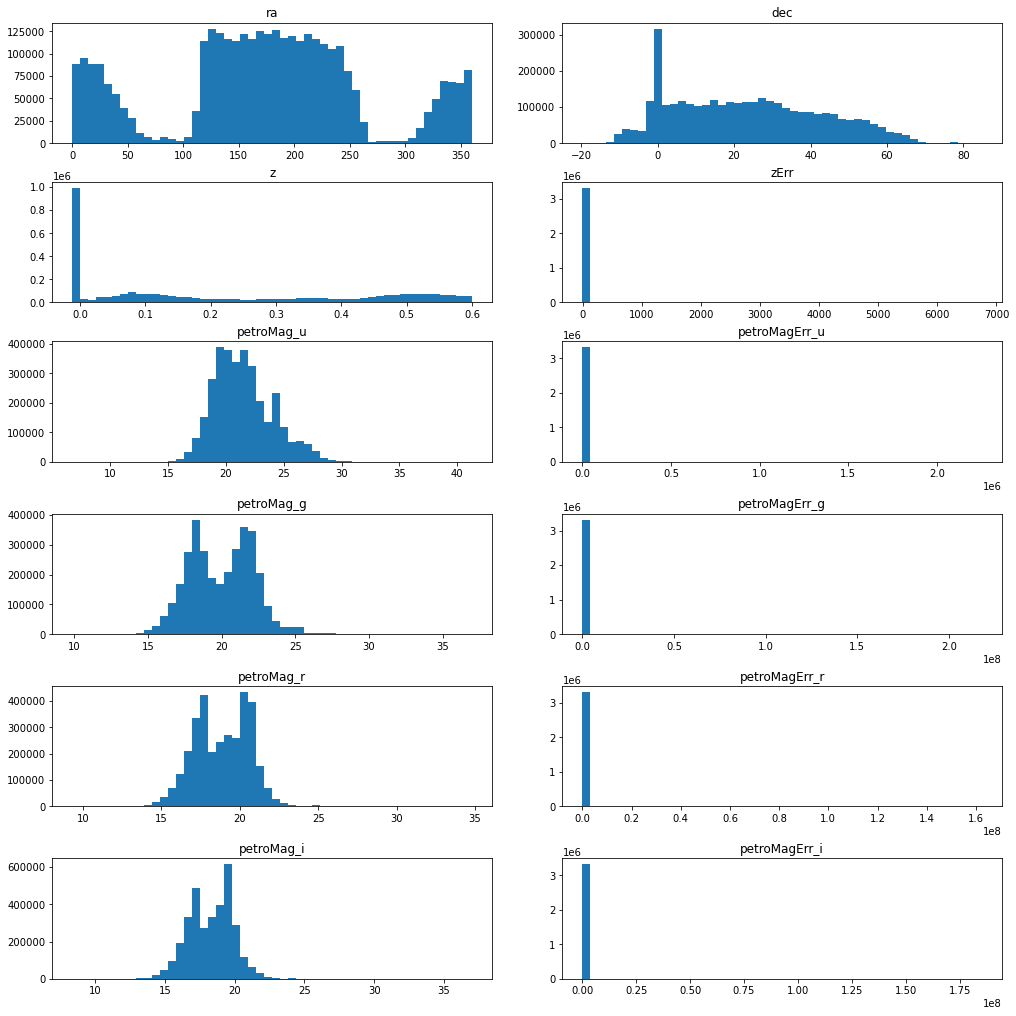

In [14]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
metade_das_colunas = (len(colunas_numéricas)+1)//2
gs = fig.add_gridspec(metade_das_colunas,2, left=0.05, right=0.5, wspace=0.05)

for i, coluna in enumerate(colunas_numéricas):
    ax = fig.add_subplot(gs[i//2, i%2])
    ax.hist(df[coluna],bins=50)
    ax.set_title(coluna)

Nota-se a concentração de z em 1.

In [15]:
classes=np.unique(df['class'])
classes

array(['GALAXY', 'QSO   ', 'STAR  '], dtype=object)

In [16]:
df['class']=df['class'].str.strip()
classes=np.unique(df['class'])
classes

array(['GALAXY', 'QSO', 'STAR'], dtype=object)

In [17]:
x = list(df.columns[4:])
x

['z',
 'zErr',
 'petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [18]:
df['classe_n']=(2 * (df['class']=='STAR'))-1
df['classe_n']

0         -1
1         -1
2         -1
3         -1
4         -1
          ..
3338062    1
3338063   -1
3338064   -1
3338065   -1
3338066   -1
Name: classe_n, Length: 3318450, dtype: int64

<AxesSubplot:>

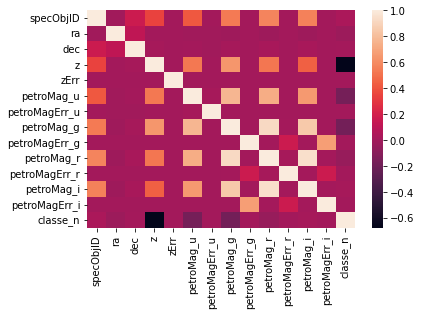

In [19]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

Notamos que _classe_n_ tem boa correlação com _z_.

# Random Forest

In [20]:
tamanho_treino = int(.7 * len(df))
tamanho_teste = int(.2 * len(df))
treino, teste, validação = np.split(df.sample(frac=1),[tamanho_treino,tamanho_treino+tamanho_teste])
print(f'{len(treino) = }, {len(teste) = }, {len(validação) = }')

len(treino) = 2322915, len(teste) = 663690, len(validação) = 331845


In [21]:
classificador_rf = [0] * 9
for i in range(9):
    classificador_rf[i] = RandomForestClassifier(n_estimators=i+1).fit(treino[x],treino['class'])

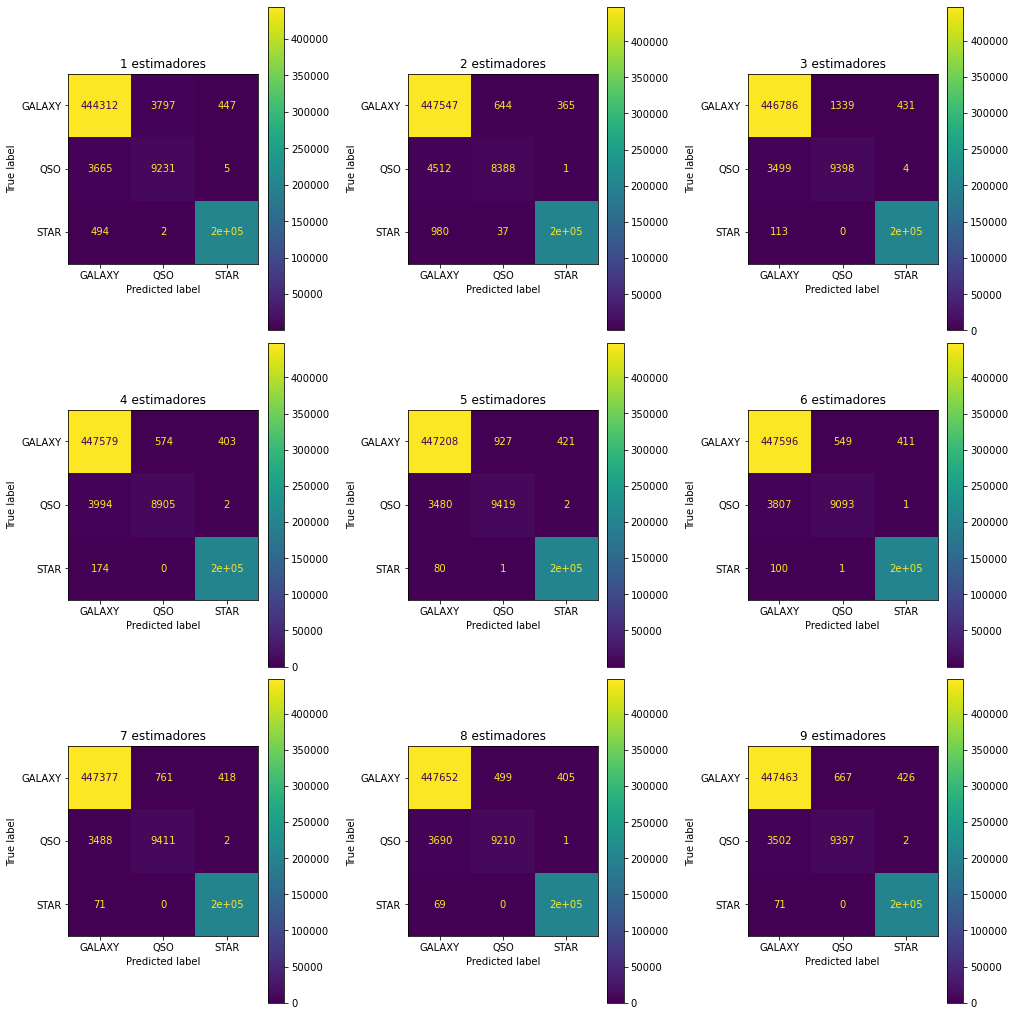

In [22]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    ConfusionMatrixDisplay.from_estimator(classificador_rf[i],teste[x],teste['class'],ax=ax)
    ax.set_title(f'{i+1} estimadores')

Nota-se que mesmo o pior classificador erra menos de 1% das classificações.

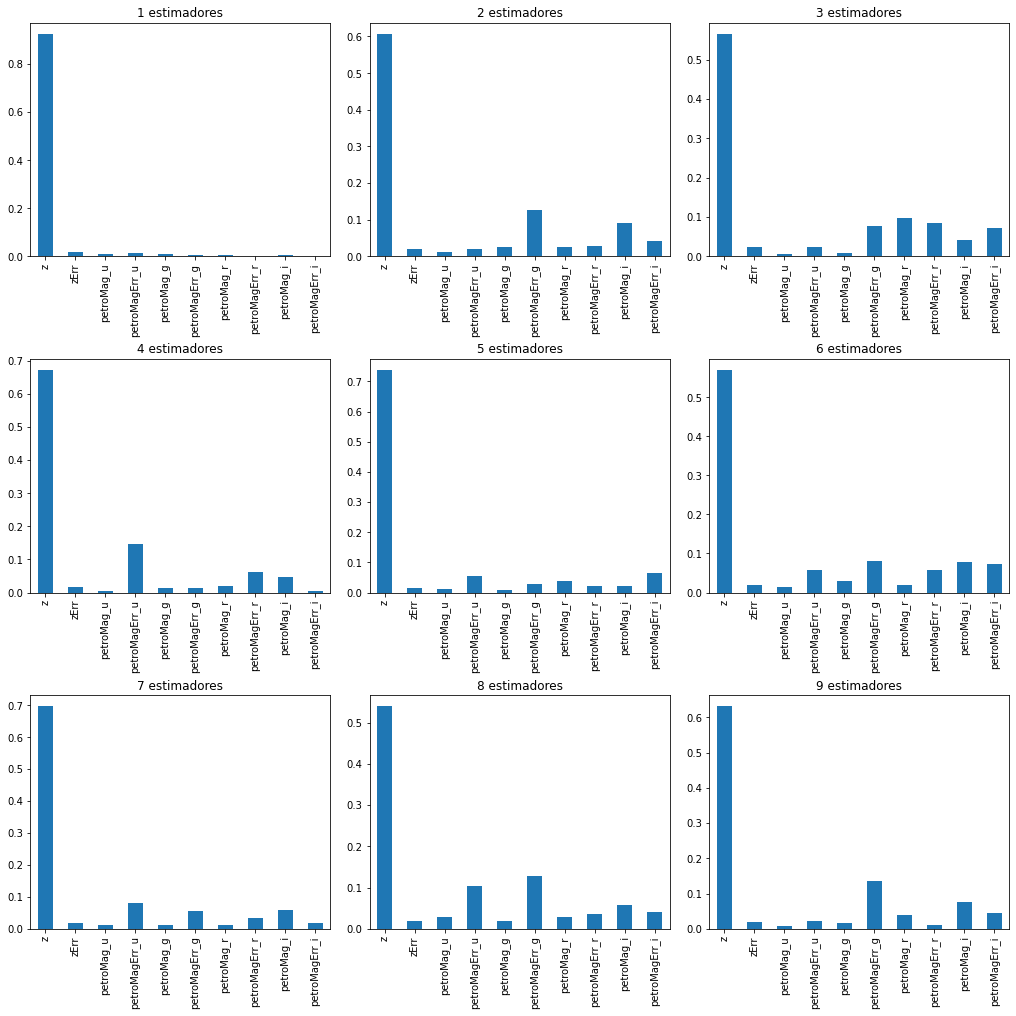

In [23]:
feature_names = list((treino[x].columns))

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    importances = classificador_rf[i].feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    ax = fig.add_subplot(gs[i//3, i%3])
    forest_importances.plot.bar(ax=ax)
    ax.set_title(f'{i+1} estimadores')

Conforme poderíamos esperar pela matriz de correlação, _z_ é o fator mais importante em qualquer classificador.

Para obter a curva ROC pracisamos de um classificador binário, então usamos _classe_n_, que tem apenas as classes estrela (+1) e não-estrela (-1):

In [24]:
classificador_rf_b = [0] * 9
for i in range(9):
    classificador_rf_b[i] = RandomForestClassifier(n_estimators=i+1).fit(treino[x],treino['classe_n'])

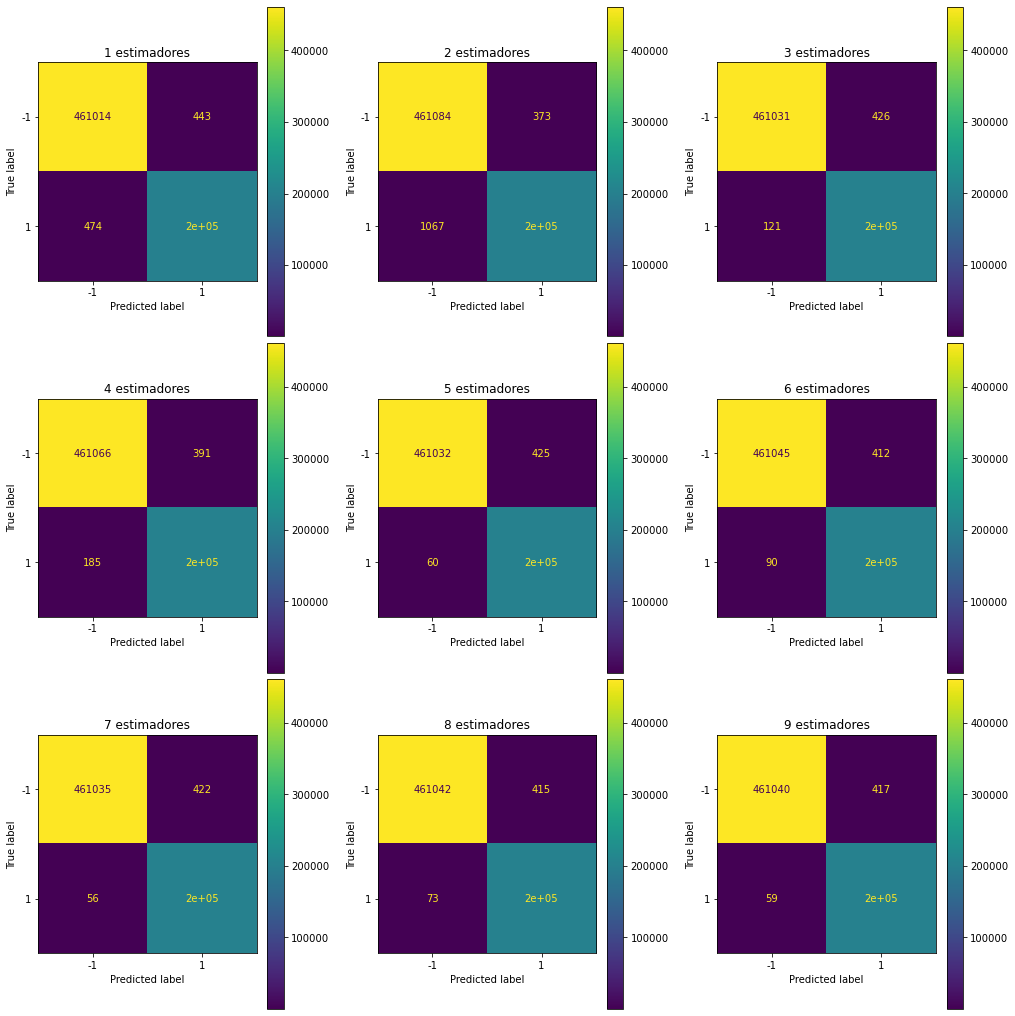

In [114]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    ConfusionMatrixDisplay.from_estimator(classificador_rf_b[i],teste[x],teste['classe_n'],ax=ax)
    ax.set_title(f'{i+1} estimadores')

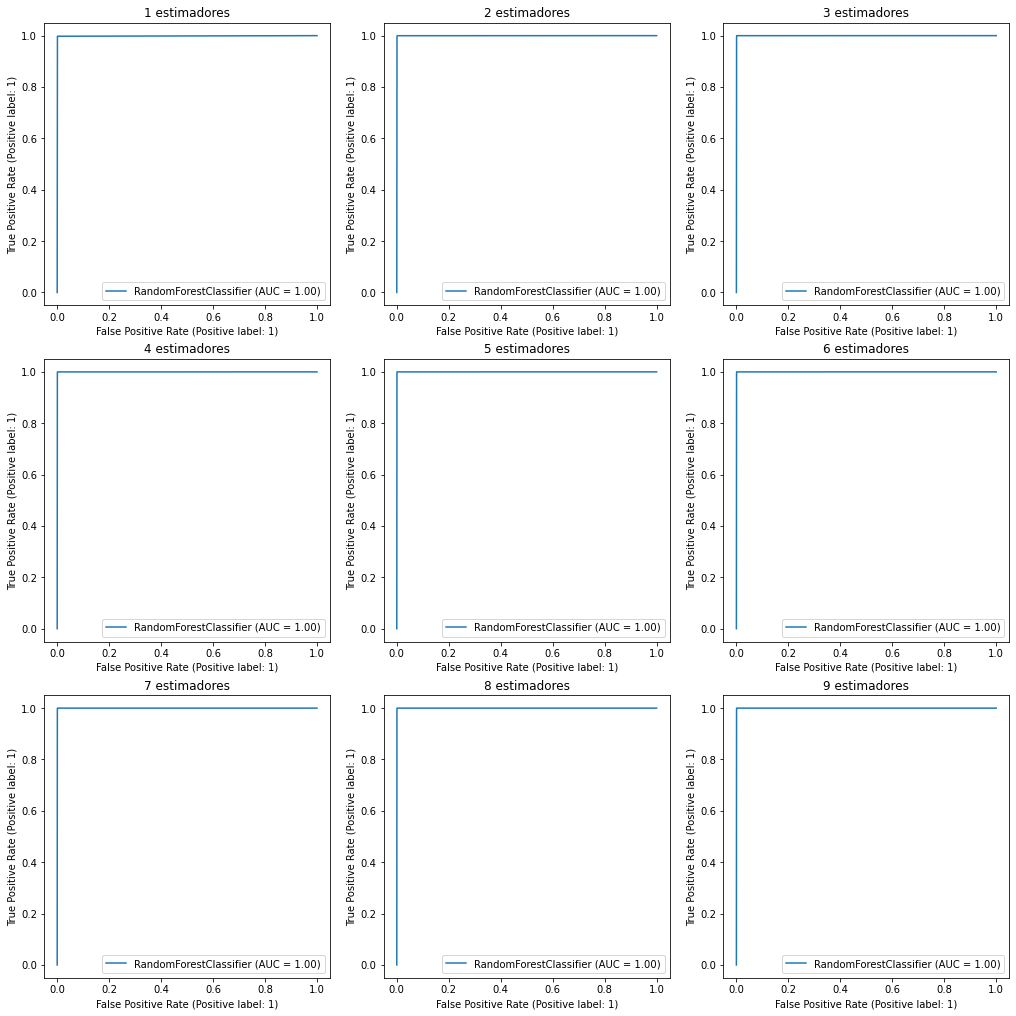

In [25]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    RocCurveDisplay.from_estimator(classificador_rf_b[i],teste[x],teste['classe_n'],ax=ax)
    ax.set_title(f'{i+1} estimadores')

Mesmo para o classificador mais simples, a AUC ficou em 1!

## Classificando sem _z_

Como o classificador se sairia sem _z_? Toda a capacidade de classificação depende desse elemento? Vamos testar sem _z_ e sem _zErr_

In [26]:
u = x[2:]
u

['petroMag_u',
 'petroMagErr_u',
 'petroMag_g',
 'petroMagErr_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMag_i',
 'petroMagErr_i']

In [27]:
classificador_rf_u = [0] * 9
for i in range(9):
    classificador_rf_u[i] = RandomForestClassifier(n_estimators=i+1).fit(treino[u],treino['classe_n'])

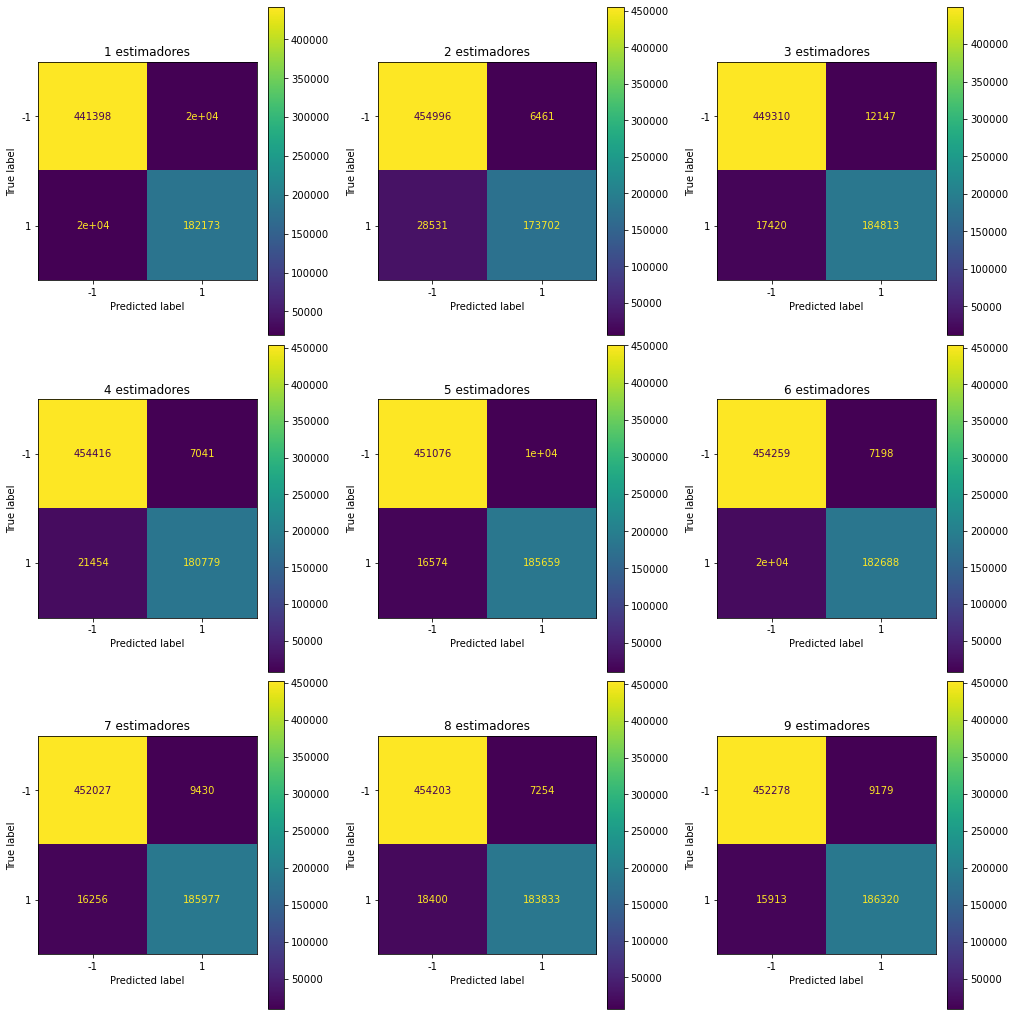

In [28]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    ConfusionMatrixDisplay.from_estimator(classificador_rf_u[i],teste[u],teste['classe_n'],ax=ax)
    ax.set_title(f'{i+1} estimadores')

Podemos ver que embora tenha um desempenho muito pior do que com _z_ à sua disposição, pudemos obter classificadores com erros na casa de 5%.

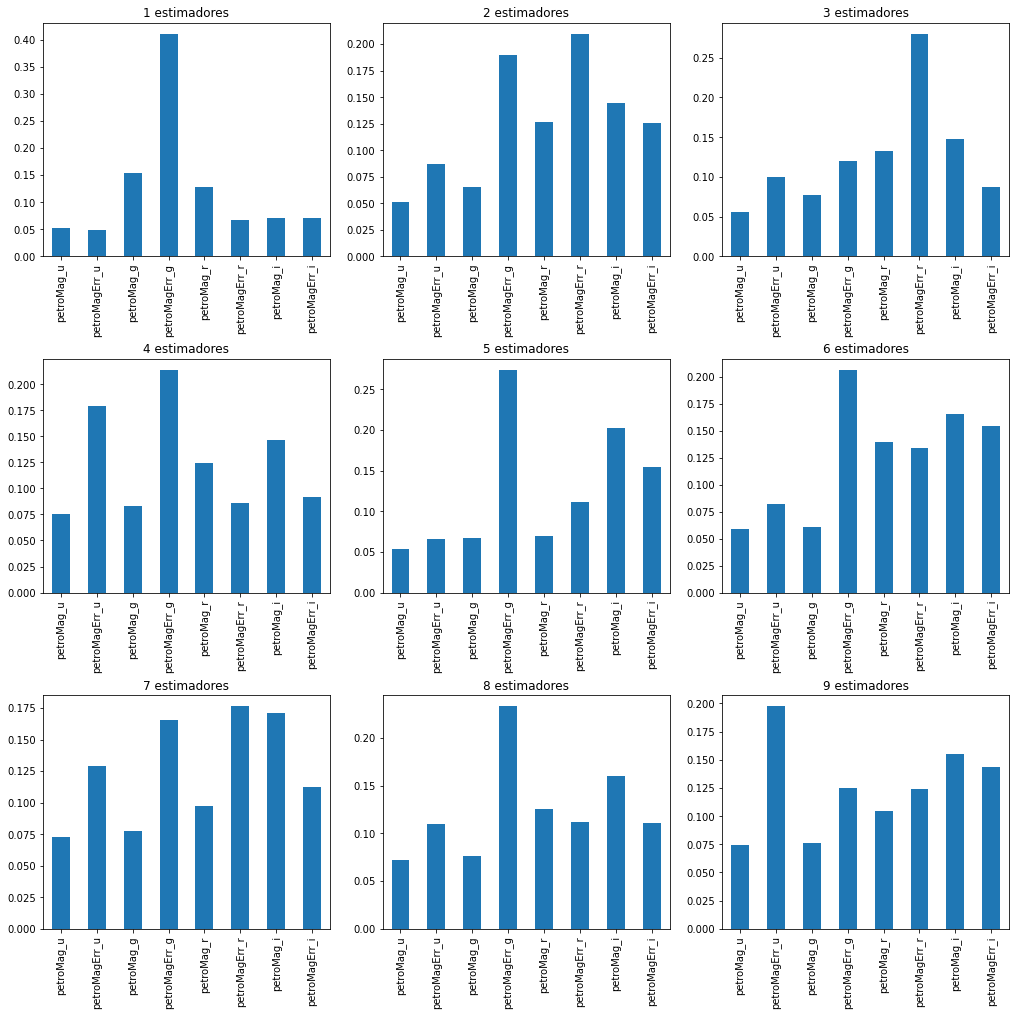

In [29]:
feature_names = list((treino[u].columns))

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    importances = classificador_rf_u[i].feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    ax = fig.add_subplot(gs[i//3, i%3])
    forest_importances.plot.bar(ax=ax)
    ax.set_title(f'{i+1} estimadores')

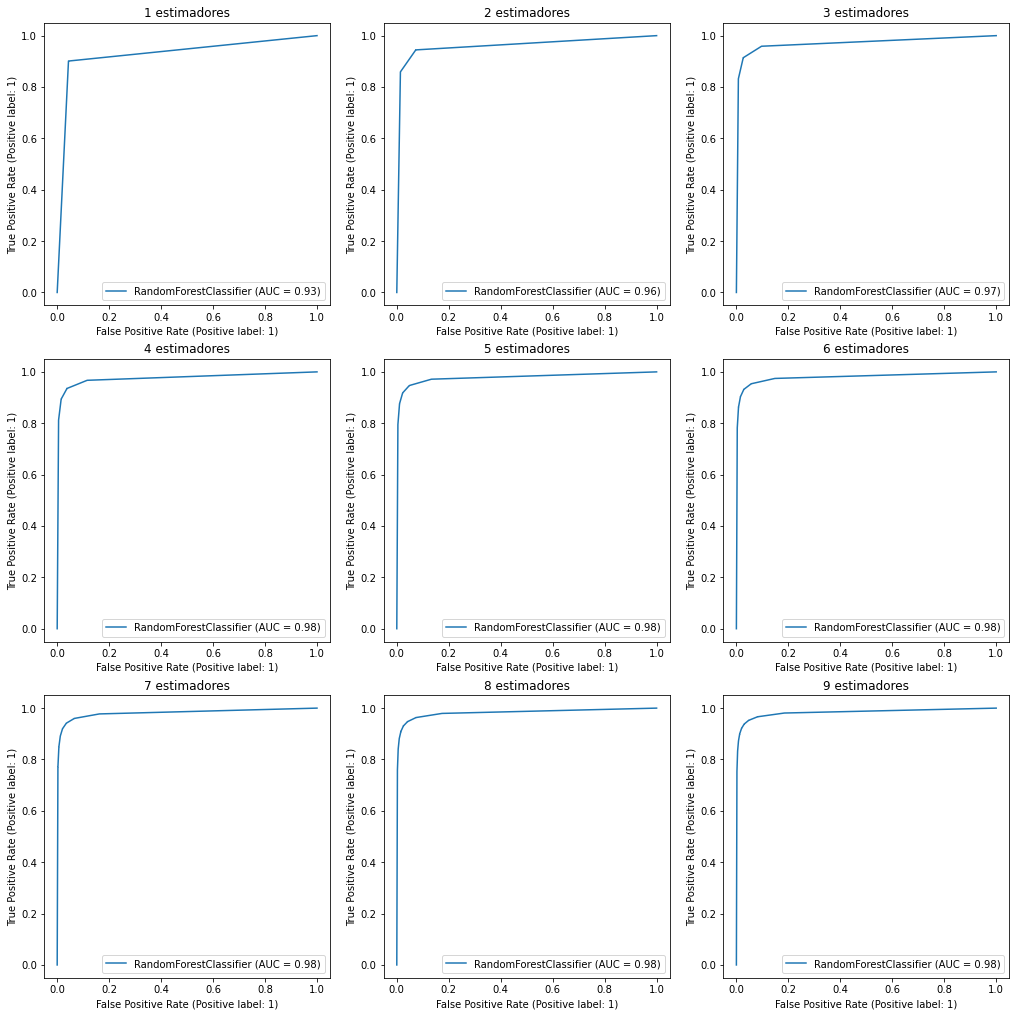

In [30]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
gs = fig.add_gridspec(3,3, left=0.05, right=0.5, wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(gs[i//3, i%3])
    RocCurveDisplay.from_estimator(classificador_rf_u[i],teste[u],teste['classe_n'],ax=ax)
    ax.set_title(f'{i+1} estimadores')

As AUCs mostram a boa capacidade de classificação das Random Forests, mesmo sem _z_.

# Logistic Regression

In [31]:
classificador_lr = LogisticRegression().fit(treino[x],treino['classe_n'])

In [32]:
predições_lr = classificador_lr.predict(teste[x])
classificador_lr.score(teste[x],teste['classe_n'])

0.6952929831698534

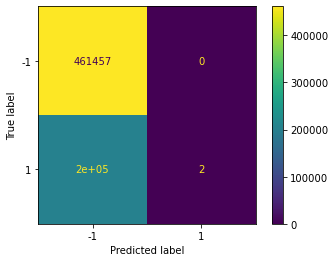

In [33]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lr)

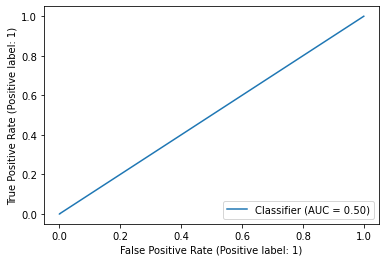

In [116]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lr)

In [34]:
sc = StandardScaler()
x_treino_escalonado = sc.fit_transform(treino[x])
x_teste_escalonado = sc.transform(teste[x])
x_validação_escalonado = sc.transform(validação[x])

In [35]:
classificador_lr_escalonado = LogisticRegression().fit(x_treino_escalonado,treino['classe_n'])

In [36]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()
x_treino_robusto = rs.fit_transform(treino[['z','zErr']])
x_teste_robusto = rs.transform(teste[['z','zErr']])
x_validação_robusto = rs.transform(validação[['z','zErr']])

In [37]:
classificador_lr_robusto = LogisticRegression()
classificador_lr_robusto.fit(x_treino_robusto,treino['classe_n'])

LogisticRegression()

In [38]:
predições_lr_robusto = classificador_lr_robusto.predict(x_teste_robusto)
classificador_lr_robusto.score(x_teste_robusto,teste['classe_n'])

0.6789148548268017

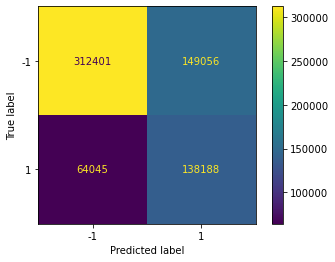

In [39]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lr_robusto)

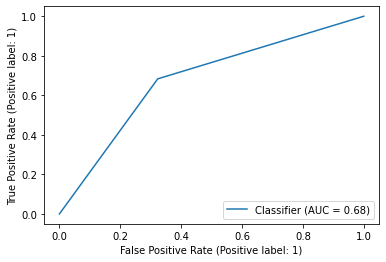

In [117]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lr_robusto)

In [40]:
classificador_lr_z = LogisticRegression().fit(np.array(treino['z']).reshape(-1,1),treino['classe_n'])
predições_lr_z = classificador_lr_z.predict(np.array(teste['z']).reshape(-1,1))
classificador_lr_z.score(np.array(teste['z']).reshape(-1,1),teste['classe_n'])

0.9952779158944688

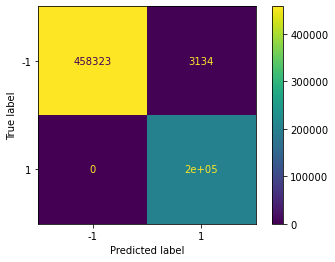

In [115]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lr_z)

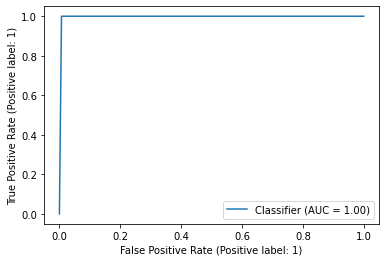

In [118]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lr_z)

# LightGBM

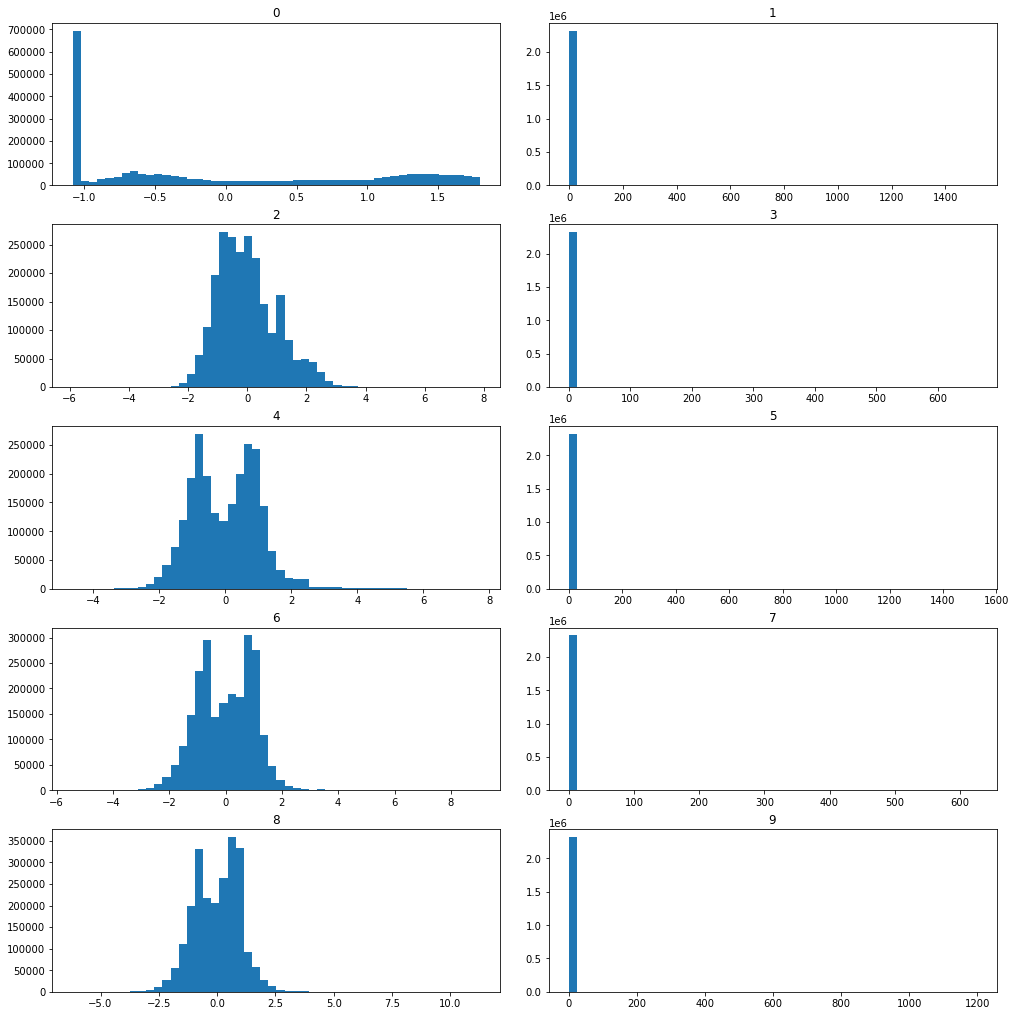

In [42]:
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
metade_das_colunas = ((x_treino_escalonado.shape[1])+1)//2
gs = fig.add_gridspec(metade_das_colunas,2, left=0.05, right=0.5, wspace=0.05)

for i, coluna in enumerate(range(x_treino_escalonado.shape[1])):
    ax = fig.add_subplot(gs[i//2, i%2])
    ax.hist(x_treino_escalonado[:,coluna],bins=50)
    ax.set_title(coluna)

In [43]:
d_treino = lgb.Dataset(x_treino_escalonado,label=treino['classe_n'])

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

regressor_lgb = lgb.train(params, d_treino,100)

[LightGBM] [Info] Number of positive: 707944, number of negative: 1614971
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 2322915, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304765 -> initscore=-0.824707
[LightGBM] [Info] Start training from score -0.824707


<Figure size 1008x1008 with 0 Axes>

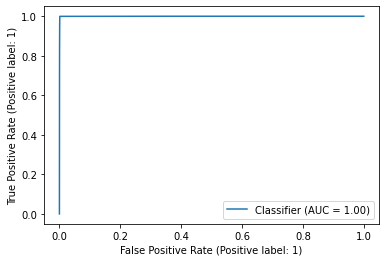

In [44]:
predições_lgb = regressor_lgb.predict(x_teste_escalonado)

fig = plt.figure(figsize=(14, 14), constrained_layout=True)
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb)

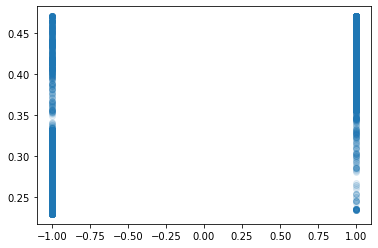

In [45]:
plt.scatter(teste['classe_n'],predições_lgb,alpha=0.1)

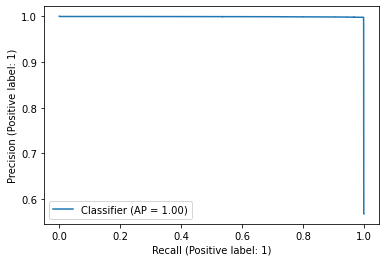

In [46]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(teste['classe_n'],predições_lgb)

(array([3.37018e+05, 3.15170e+04, 1.80200e+04, 8.64200e+03, 1.04420e+04,
        1.79610e+04, 7.54700e+03, 8.18500e+03, 9.16900e+03, 4.14900e+03,
        4.62800e+03, 3.64500e+03, 1.70000e+02, 2.30000e+01, 2.90000e+01,
        1.49000e+02, 1.78500e+03, 1.61800e+03, 1.65100e+03, 2.33600e+03,
        1.61500e+03, 1.79200e+03, 7.13900e+03, 1.01320e+04, 8.49300e+03,
        1.48820e+04, 2.21440e+04, 1.89980e+04, 3.51090e+04, 7.47020e+04]),
 array([0.22953199, 0.23755689, 0.24558179, 0.25360669, 0.26163159,
        0.2696565 , 0.2776814 , 0.2857063 , 0.2937312 , 0.3017561 ,
        0.309781  , 0.3178059 , 0.3258308 , 0.3338557 , 0.3418806 ,
        0.34990551, 0.35793041, 0.36595531, 0.37398021, 0.38200511,
        0.39003001, 0.39805491, 0.40607981, 0.41410471, 0.42212961,
        0.43015452, 0.43817942, 0.44620432, 0.45422922, 0.46225412,
        0.47027902]),
 <BarContainer object of 30 artists>)

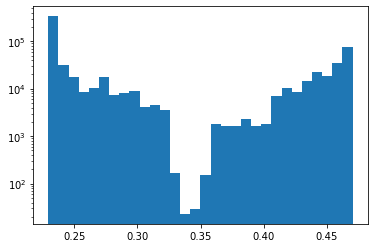

In [47]:
plt.hist(predições_lgb,bins=30,log=True)

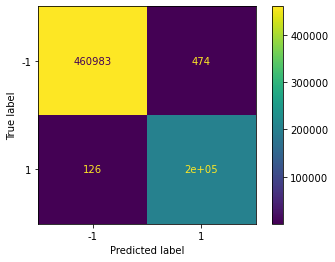

In [48]:
predições_lgb_b = (predições_lgb>0.34)*2 - 1
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgb_b)

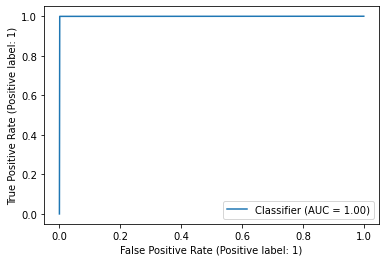

In [119]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb_b)

In [49]:
classificador_lgbc = lgb.LGBMClassifier()
classificador_lgbc.fit(x_treino_escalonado, treino['classe_n'])

LGBMClassifier()

In [50]:
predições_lgbc = classificador_lgbc.predict(x_teste_escalonado)

from sklearn.metrics import accuracy_score
accuracy_score(teste['classe_n'],predições_lgbc)

0.9990070665521553

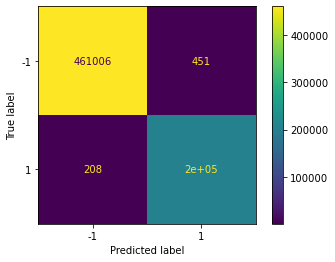

In [51]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgbc)

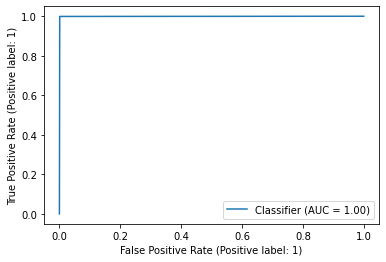

In [120]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgbc)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(teste['classe_n'],predições_lgbc))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00    461457
           1       1.00      1.00      1.00    202233

    accuracy                           1.00    663690
   macro avg       1.00      1.00      1.00    663690
weighted avg       1.00      1.00      1.00    663690



## LightGBM sem _z_

In [53]:
sc_u = StandardScaler()
u_treino_escalonado = sc_u.fit_transform(treino[u])
u_teste_escalonado = sc_u.transform(teste[u])
u_validação_escalonado = sc_u.transform(validação[u])

In [54]:
d_treino_u = lgb.Dataset(u_treino_escalonado,label=treino['classe_n'])

params = {}
params['learning_rate'] = 0.003
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = 'binary_logloss'
params['sub_feature'] = 0.5
params['num_leaves'] = 10
params['min_data'] = 50
params['max_depth'] = 10

regressor_lgb_u = lgb.train(params, d_treino_u,100)

[LightGBM] [Info] Number of positive: 707944, number of negative: 1614971
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 2322915, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.304765 -> initscore=-0.824707
[LightGBM] [Info] Start training from score -0.824707


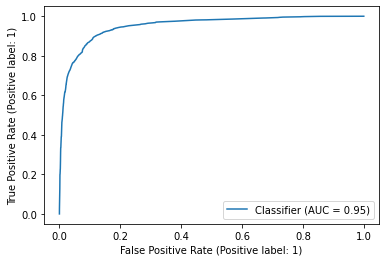

In [55]:
predições_lgb_u = regressor_lgb_u.predict(u_teste_escalonado)

RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb_u)

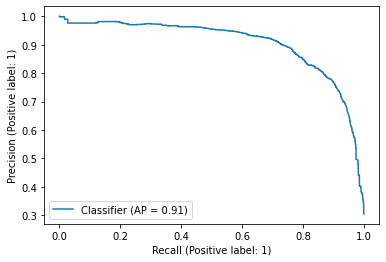

In [56]:
display = PrecisionRecallDisplay.from_predictions(teste['classe_n'],predições_lgb_u)

(array([128577., 202134.,  39756.,  19983.,  10799.,   6489.,   6757.,
          4492.,   4451.,   4157.,   5481.,   6859.,   5672.,   7308.,
         25837.,   6408.,   5950.,   5255.,   5735.,   5800.,   5744.,
          6881.,   7406.,   9074.,  10971.,   9867.,  13287.,  25147.,
         28234.,  39179.]),
 array([0.23813721, 0.24539315, 0.25264909, 0.25990503, 0.26716097,
        0.27441691, 0.28167286, 0.2889288 , 0.29618474, 0.30344068,
        0.31069662, 0.31795256, 0.3252085 , 0.33246444, 0.33972039,
        0.34697633, 0.35423227, 0.36148821, 0.36874415, 0.37600009,
        0.38325603, 0.39051197, 0.39776792, 0.40502386, 0.4122798 ,
        0.41953574, 0.42679168, 0.43404762, 0.44130356, 0.4485595 ,
        0.45581544]),
 <BarContainer object of 30 artists>)

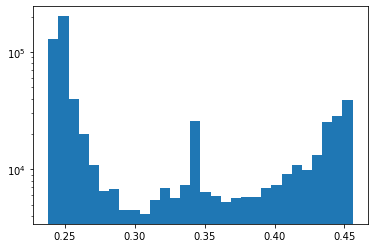

In [57]:
plt.hist(predições_lgb_u,bins=30,log=True)

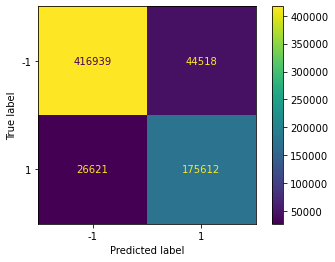

In [58]:
predições_lgb_b_u = (predições_lgb_u>0.33)*2 - 1
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgb_b_u)

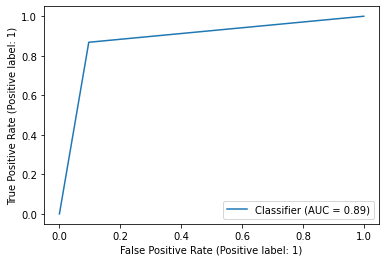

In [123]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgb_b_u)

In [59]:
classificador_lgbc_u = lgb.LGBMClassifier()
classificador_lgbc_u.fit(u_treino_escalonado, treino['classe_n'])

LGBMClassifier()

In [60]:
predições_lgbc_u = classificador_lgbc_u.predict(u_teste_escalonado)

accuracy_score(teste['classe_n'],predições_lgbc_u)

0.9537223703837635

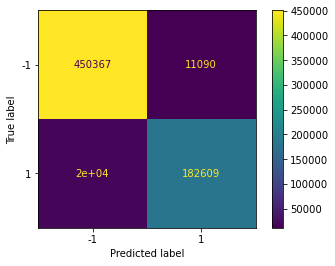

In [61]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_lgbc_u)

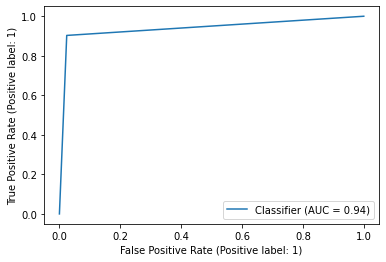

In [122]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_lgbc_u)

In [62]:
print(classification_report(teste['classe_n'],predições_lgbc_u))

              precision    recall  f1-score   support

          -1       0.96      0.98      0.97    461457
           1       0.94      0.90      0.92    202233

    accuracy                           0.95    663690
   macro avg       0.95      0.94      0.94    663690
weighted avg       0.95      0.95      0.95    663690



# TabNet

In [85]:
from pytorch_tabnet.tab_model import TabNetClassifier

classificador_tabnet = TabNetClassifier(verbose=0,seed=42)
classificador_tabnet.fit(X_train=treino[x].to_numpy(), y_train=treino['classe_n'].to_numpy(),patience=5,max_epochs=100, eval_metric=['auc'],
    eval_set=[(treino[x].to_numpy(),treino['classe_n'].to_numpy()),
              (validação[x].to_numpy(),validação['classe_n'].to_numpy())
             ],
    eval_name=('treino','validação'))



Early stopping occurred at epoch 7 with best_epoch = 2 and best_validação_auc = 0.99969
Best weights from best epoch are automatically used!


In [86]:
predições_tabnet = classificador_tabnet.predict_proba(teste[x].to_numpy())[:,1]

(array([4.61273e+05, 2.67000e+02, 1.44000e+03, 7.13500e+03, 3.32980e+04,
        3.11790e+04, 3.11060e+04, 6.44260e+04, 2.62690e+04, 7.29700e+03]),
 array([0.        , 0.09992886, 0.19985771, 0.29978657, 0.39971542,
        0.49964428, 0.59957314, 0.699502  , 0.79943085, 0.8993597 ,
        0.99928856], dtype=float32),
 <BarContainer object of 10 artists>)

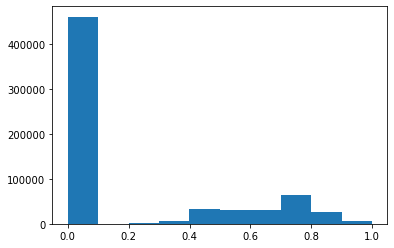

In [87]:
plt.hist(predições_tabnet)

In [94]:
predições_tabnet_b = (predições_tabnet>.1)*2 -1

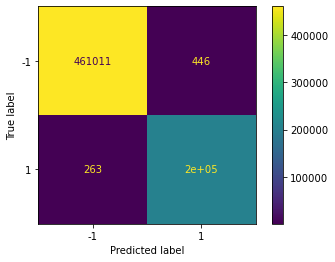

In [95]:
ConfusionMatrixDisplay.from_predictions(teste['classe_n'],predições_tabnet_b) 

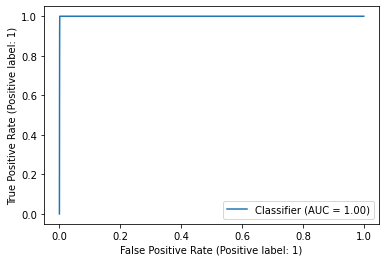

In [125]:
RocCurveDisplay.from_predictions(teste['classe_n'],predições_tabnet)

# Performance

In [99]:
tempos = {}
for idx, clf in enumerate(classificador_rf_b):
    início = time.perf_counter()
    clf.predict(teste[x])
    fim = time.perf_counter()
    tempos[f'Random Forest {idx+1}']=fim-início

print(tempos)

{'Random Forest 1': 0.0588803329737857, 'Random Forest 2': 0.0906884580035694, 'Random Forest 3': 0.10597712500020862, 'Random Forest 4': 0.15572679199976847, 'Random Forest 5': 0.18336387496674433, 'Random Forest 6': 0.202785000030417, 'Random Forest 7': 0.2421968340058811, 'Random Forest 8': 0.26773416699143127, 'Random Forest 9': 0.3052954580052756}


In [103]:
tmp = np.array(teste['z']).reshape(-1,1)
início = time.perf_counter()
classificador_lr_z.predict(tmp)
fim = time.perf_counter()
del tmp
tempos['Logistic Regression']=fim-início
tempos

{'Random Forest 1': 0.0588803329737857,
 'Random Forest 2': 0.0906884580035694,
 'Random Forest 3': 0.10597712500020862,
 'Random Forest 4': 0.15572679199976847,
 'Random Forest 5': 0.18336387496674433,
 'Random Forest 6': 0.202785000030417,
 'Random Forest 7': 0.2421968340058811,
 'Random Forest 8': 0.26773416699143127,
 'Random Forest 9': 0.3052954580052756,
 'Logistic Regression': 0.01998412498505786,
 'LightGBM': 0.4753461660002358,
 'TabNet': 7.917097874975298}

In [101]:
início = time.perf_counter()
classificador_lgbc.predict(x_teste_escalonado)
fim = time.perf_counter()
tempos['LightGBM']=fim-início
tempos

{'Random Forest 1': 0.0588803329737857,
 'Random Forest 2': 0.0906884580035694,
 'Random Forest 3': 0.10597712500020862,
 'Random Forest 4': 0.15572679199976847,
 'Random Forest 5': 0.18336387496674433,
 'Random Forest 6': 0.202785000030417,
 'Random Forest 7': 0.2421968340058811,
 'Random Forest 8': 0.26773416699143127,
 'Random Forest 9': 0.3052954580052756,
 'Logistic Regression': 0.011911417008377612,
 'LightGBM': 0.4753461660002358}

In [104]:
tmp = teste[x].to_numpy()
início = time.perf_counter()
classificador_tabnet.predict_proba(tmp)
fim = time.perf_counter()
del tmp
tempos['TabNet']=fim-início
tempos

{'Random Forest 1': 0.0588803329737857,
 'Random Forest 2': 0.0906884580035694,
 'Random Forest 3': 0.10597712500020862,
 'Random Forest 4': 0.15572679199976847,
 'Random Forest 5': 0.18336387496674433,
 'Random Forest 6': 0.202785000030417,
 'Random Forest 7': 0.2421968340058811,
 'Random Forest 8': 0.26773416699143127,
 'Random Forest 9': 0.3052954580052756,
 'Logistic Regression': 0.01998412498505786,
 'LightGBM': 0.4753461660002358,
 'TabNet': 8.154303291987162}

<BarContainer object of 12 artists>

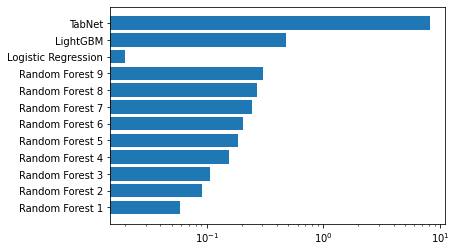

In [113]:
plt.barh(list(tempos.keys()),tempos.values(),log=True)